In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

In [3]:
from fastai.vision import * 
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/thomassw66/.fastai/data/camvid/labels'),
 PosixPath('/home/thomassw66/.fastai/data/camvid/images'),
 PosixPath('/home/thomassw66/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/thomassw66/.fastai/data/camvid/valid.txt')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/thomassw66/.fastai/data/camvid/images/Seq05VD_f02970.png'),
 PosixPath('/home/thomassw66/.fastai/data/camvid/images/0016E5_08065.png'),
 PosixPath('/home/thomassw66/.fastai/data/camvid/images/0016E5_07920.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/thomassw66/.fastai/data/camvid/labels/Seq05VD_f00990_P.png'),
 PosixPath('/home/thomassw66/.fastai/data/camvid/labels/0006R0_f02430_P.png'),
 PosixPath('/home/thomassw66/.fastai/data/camvid/labels/0016E5_07965_P.png')]

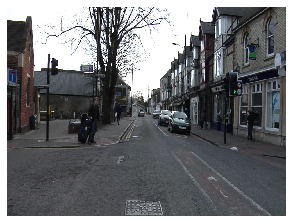

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'


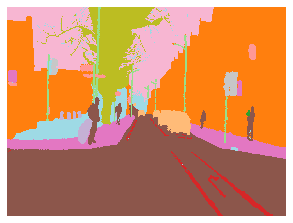

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [82]:
src_size = np.array(mask.shape[1:])
print(src_size)
mask.data

[720 960]


tensor([[[21, 21, 21,  ...,  4,  4,  4],
         [21, 21, 21,  ...,  4,  4,  4],
         [21, 21, 21,  ...,  4,  4,  4],
         ...,
         [17, 17, 17,  ..., 17, 17, 17],
         [17, 17, 17,  ..., 17, 17, 17],
         [17, 17, 17,  ..., 17, 17, 17]]])

In [83]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes 

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [84]:
size = src_size // 2 
free = gpu_mem_get_free_no_cache()
if free > 8200: bs = 8 
else:           bs = 4 
print(f"using bs={bs}, have {free}MB of GPU Ram free")

using bs=8, have 8729MB of GPU Ram free


In [85]:
src = (SegmentationItemList.from_folder(path_img)
    .split_by_fname_file("../valid.txt")
    .label_from_func(get_y_fn, classes = codes))



In [86]:
print(size)
data = (src.transform(get_transforms(), size=size, tfm_y=True)
           .databunch(bs=bs)
           .normalize(imagenet_stats))

[360 480]


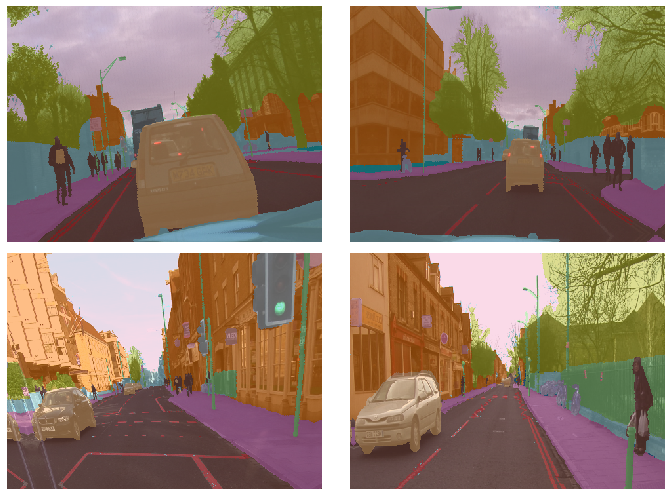

In [87]:
data.show_batch(2, figsize=(10,7))

In [88]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [89]:
metrics = acc_camvid
# metrics = accuracy


In [92]:
wd=1e-5

In [108]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


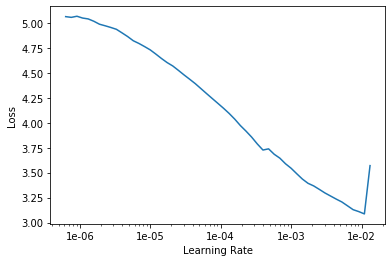

In [94]:
lr_find(learn)
learn.recorder.plot()

In [98]:
??learn.fit_one_cycle

In [99]:
lr = 3e-3
learn.fit_one_cycle(10, max_lr=lr)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.260746,0.902143,0.792605,00:50
1,0.897963,0.816333,0.817777,00:50
2,0.748962,0.601776,0.835180,00:50
3,0.660682,0.498077,0.873208,00:49
4,0.561776,0.429722,0.881087,00:49
5,0.513034,0.399801,0.882081,00:49
6,0.456853,0.382419,0.886969,00:50
7,0.410423,0.342940,0.897205,00:49
8,0.372053,0.305149,0.914904,00:50
9,0.348675,0.303017,0.909142,00:50


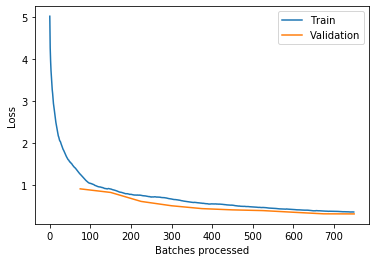

In [100]:
learn.recorder.plot_losses()

In [101]:
learn.save('stage-1-camvid-unet-resnet34')

In [109]:
learn.load('stage-1-camvid-unet-resnet34');

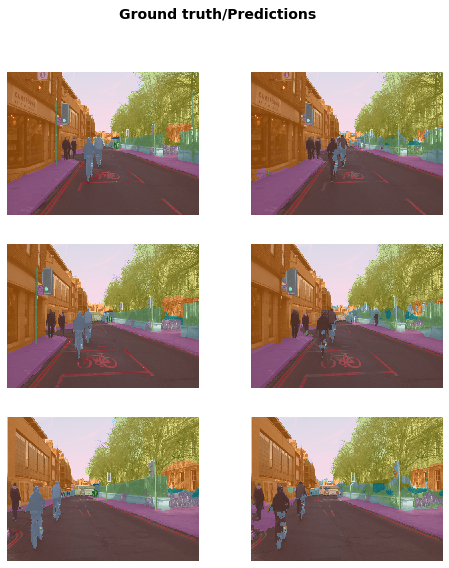

In [110]:
learn.show_results(rows=3, figsize=(8,9))

In [111]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


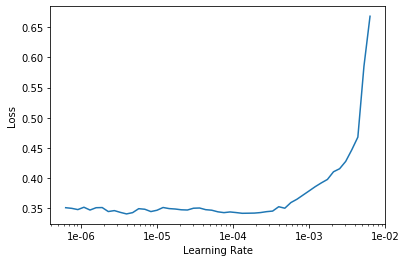

In [112]:
lr_find(learn)
learn.recorder.plot()

In [114]:
lrs = slice(1e-5, 1e-4)

In [115]:
learn.fit_one_cycle(4, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.339827,0.294580,0.917470,00:51
1,0.324865,0.293746,0.916001,00:51
2,0.315940,0.286711,0.918622,00:52
3,0.301504,0.286234,0.918091,00:52


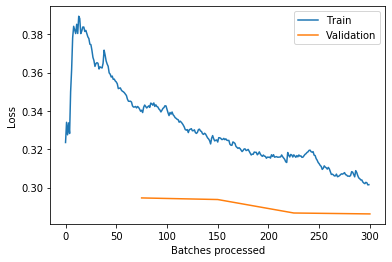

In [117]:
learn.recorder.plot_losses()

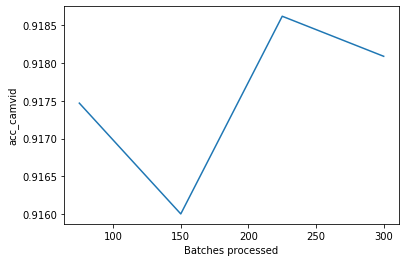

In [118]:
learn.recorder.plot_metrics()

In [119]:
learn.save('stage-2-camvid-unet-resnet34');

In [120]:
learn.destroy() 
size = src_size

bs = 1

this Learner object self-destroyed - it still exists, but no longer usable


In [121]:
data = (src.transform(get_transforms(), size = size, tfm_y=True)
           .databunch(bs=bs)
           .normalize(imagenet_stats))

In [122]:
print(size)

[720 960]


In [123]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [130]:
learn.load('stage-2-camvid-unet-resnet34')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/thomassw66/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/thomassw66/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


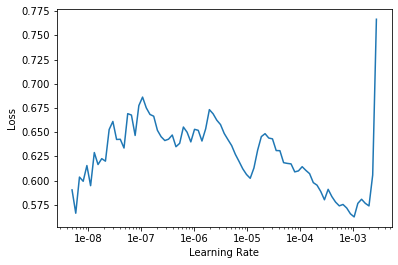

In [131]:
lr_find(learn, start_lr=1e-9, end_lr=1e-2)
learn.recorder.plot()

In [132]:
lr = 1e-4
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.526805,0.402765,0.897787,03:22
1,0.415804,0.327510,0.907467,03:22
2,0.361246,0.314897,0.912571,03:22
3,0.321105,0.288366,0.918557,03:22


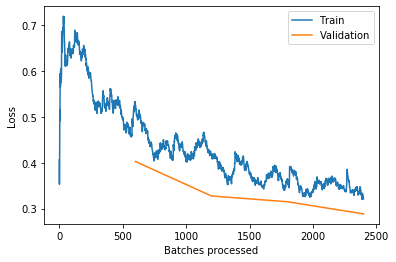

In [133]:
learn.recorder.plot_losses()

In [134]:
learn.save('stage-2-big-camvid-unet-resnet34')

In [64]:
# learn.load('stage-2-big-camvid-unet-resnet34')

In [135]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


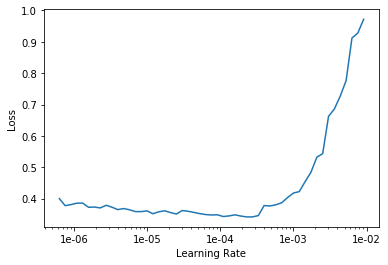

In [136]:
lr_find(learn)
learn.recorder.plot()

In [137]:
lrs = slice(1e-6, 3e-5)

In [138]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.314859,0.275606,0.923348,03:31
1,0.319574,0.283242,0.919321,03:31
2,0.318765,0.286866,0.918556,03:31
3,0.310700,0.267204,0.923964,03:32
4,0.285244,0.264378,0.925655,03:31
5,0.311658,0.270961,0.922932,03:32
6,0.257411,0.262292,0.925221,03:31
7,0.250804,0.253364,0.927930,03:31
8,0.250732,0.254353,0.927326,03:32
9,0.246104,0.271063,0.923316,03:31


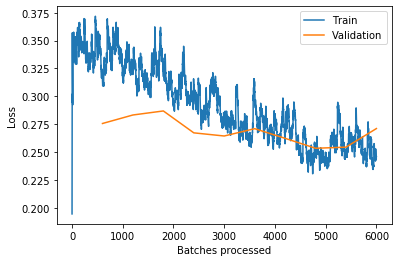

In [139]:
learn.recorder.plot_losses()

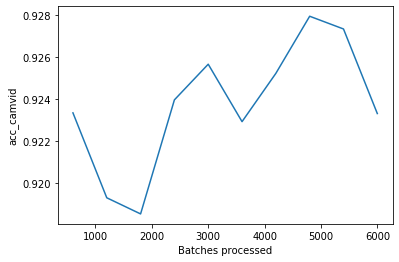

In [140]:
learn.recorder.plot_metrics()

In [141]:
learn.save('stage-3-big-camvid-unet-resnet34')

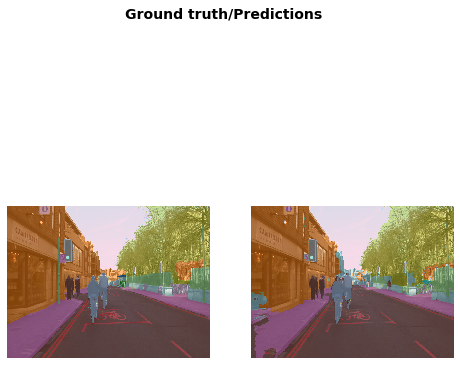

In [146]:
learn.show_results(rows=1, figsize=(8,8))

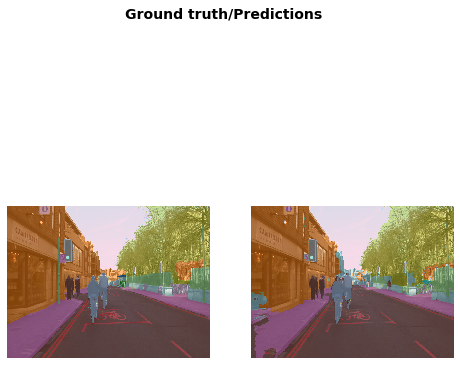

In [147]:
learn.show_results(rows=1, figsize=(8,8))

In [81]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable
